## Mini-project: Building a 1D CNN for classification of waveforms ##

## Based on original by Dr. Antonin Vacheret


This project is about designing a 1D Convolutional Neural Net (CNN) that classifies digitised signals from two types of scintillating materials used to record particle energy. 

There are many signal processing tasks where it is important to separate the signals recorded in different categories. Due to the complex features of the signals recorded, a computer vision solution is well suited for solving this problem. 

We are dealing with two type of signals: 

* The first type of material is an organic scintillator (PVT) with a fast time response of a few nanoseconds. These fasts signals are also called Electron Scintillation (ES) signals.  

* The second type of material is an inorganic scintillator to detect neutrons (ZnS(Ag)), one of the oldest scintillators used. When a neutron is detected, the scintillation signal is a long trail of fast pulses that slowly decreases in amplitude. These slow signals are called Nuclear Scintillation (NS) signals. 

We are interested here in separating as well as possible each type of signal and therefore coming up with a model that is able to have a very high score at predicting each class of signal.

Numpy files for the training and testing datasets (xtrain.npy, ytrain.npy) and their labels are already prepared. Each digitised waveform is a 1000 samples long with recorded pulses starting at a fixed time around 250 samples. Some examples of how to look at each signals and their label is provided below. Both type of signals have their amplitude normalised to the smallest pulse detectable i.e. what we call the 1 Photo-electron pulse. 

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
# choose your preferred font size and style here for plots
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 12
#plt.rcParams['font.family'] = 'Times'
#plt.rcParams['font.serif'] = 'Times'

In [2]:
# importing the datasets
xtrain = np.load("./Data/x_train.npy")
ytrain = np.load("./Data/y_train.npy")
xtest = np.load("./Data/x_test.npy")
ytest = np.load("./Data/y_test.npy")
print(xtrain.shape,xtest.shape)

(12302, 1000) (3076, 1000)


Below we are displaying a few examples from the training set to get a feel for the variability of the signal waveforms. 

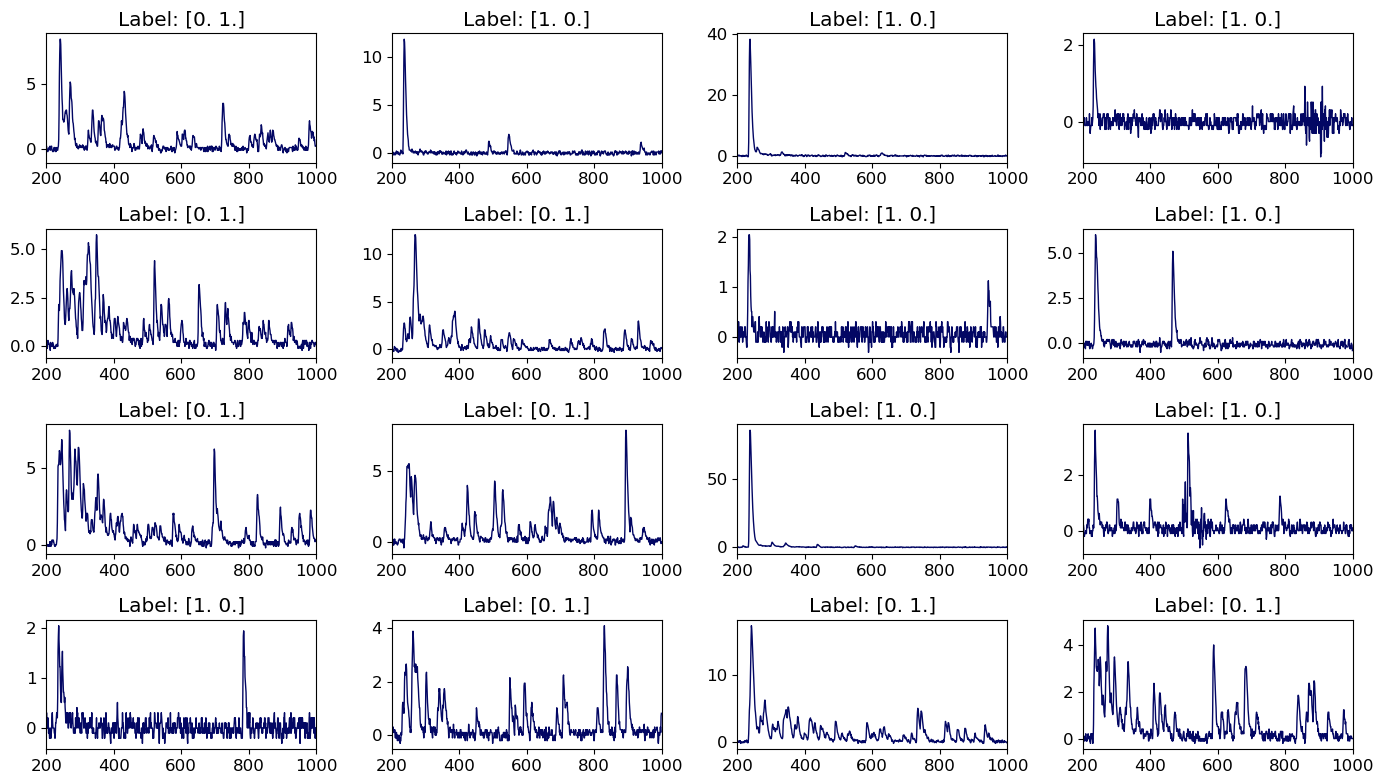

In [3]:
fig, ax = plt.subplots(4, 4, figsize=(14, 8))
ax = ax.flatten()
for i in range(0, 16):
    j = np.random.randint(0, len(xtrain))
    #print(j)
    ax[i].plot(xtrain[j],color='xkcd:darkblue',lw=1)
    ax[i].set_title("Label: {}".format(ytrain[j]))
    ax[i].set_xlim(200., 1000) #used to zoom around trigger time
fig.tight_layout()

The fast ES signals have labels ```[1,0]``` and the slower signals NS from neutrons have the other value ```[0,1]```. Notice that you can have some small pulses present later in the waveform for ES signals but generally not with the same density as NS signals.   

### Your project: Building a 1-dimensional CNN to classify the waveforms

* The relatively large differences between these two type of signals means the classification with simple pulse processing method yields an Area Under the curve (Integral of the ROC curve) of better than 95%. It is therefore expected that a well designed CNN provides an AUC > 95% with the aim to reach better than 99%.
* It is expected that datasets and dataloaders are implemented. Example of visualisation of plots showing features of the waveforms with some discussion is also expected. 
* The steps in designing and optimising the architecture should be clearly presented with a schematic of the final model architecture. It is important to explain why you have chosen some specific parameters or functions and don't hesitate the cite the literature if you have find the information in an article. 
* training/testing Loss and Accuracy and other parameters of the training should also be shown along with the final results. 
* Provide a plot with the output of the model for each class as well as the final ROC curve and AUC. 
* Feel free to add feature maps and other visualisation to support your discussion of performance and why

# List of contents
# Table of Contents
1. [Introduction](#Introduction)
2. [Building Model and Testing](#Model-Build)
3. [Fine Tuning the Parameters](#Test-Validation)
4. [Conclusion](#Conclusion)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import warnings
warnings.filterwarnings("ignore",category=UserWarning)
print("Module Loaded Okay")
# To ensure the consistency, we need to set a seed
torch.seed = 42

Module Loaded Okay


## Introduction

We firstly need to split the data sets into train set, validation set and train set. Note that the reason why we need test set and validation set is that we need to fine tuning our hyperparameters based on the validation set. As a result, it might be "learning" the validation set, and thus we need to seperate the validation set and test set.

In [5]:
#define the macro we are going to use
batch_size = 5

#transfer ytrain into two scaler labels

def toScaler_binary(input_array, classes):
    output_array = []
    for i in input_array:
        current_val = 1. if (i == classes[0]).all() else 0.
        output_array.append(current_val)
    return np.array(output_array)

classifcation = [np.array([1.,0.]) , np.array([0.,1.])]
ytrain_binary = toScaler_binary(ytrain, classifcation)
ytest_binary = toScaler_binary(ytest, classifcation)

#we firstly transfer our python dataset into pytorch tensor
tensor_xtrain = torch.tensor(xtrain, dtype = torch.double)
tensor_ytrain = torch.tensor(ytrain_binary, dtype = torch.long)
tensor_xtest  = torch.tensor(xtest, dtype = torch.double)
tensor_ytest  = torch.tensor(ytest_binary, dtype = torch.long)

#transform the data shape
tensor_xtrain = torch.reshape(tensor_xtrain,(len(tensor_xtrain),1,len(tensor_xtrain[0])))
tensor_xtest  = torch.reshape(tensor_xtest,(len(tensor_xtest),1,len(tensor_xtest[0])))

#combine the tensor into dataset
train_set = torch.utils.data.TensorDataset(tensor_xtrain, tensor_ytrain)
test_set  = torch.utils.data.TensorDataset(tensor_xtest, tensor_ytest)

#split the train set and validation set
train_set, val_set = torch.utils.data.random_split(train_set, [0.7,0.3])

#now we use the torch data loader
train_loader = torch.utils.data.DataLoader(train_set,batch_size = batch_size, shuffle = True, num_workers = 2)
val_loader   = torch.utils.data.DataLoader(val_set,  batch_size = batch_size, shuffle = False, num_workers = 2)
test_loader  = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle = False, num_workers = 2)

#two classes
classes = ("ES","NS")

Before we will train the model, let us first consider the effect of the convolutional kernel and see what kind of feature that we can pick up by manually varying the kernel.

In [6]:
#load a test data
feature_loader = torch.utils.data.DataLoader(train_set, batch_size = 1, shuffle = True)
featureiter = iter(feature_loader)
data, label = next(featureiter)

#construct the convolutional neural network manually
#this is a weight that detects a peak, and its dimensionality is 19
weights = torch.tensor([[[0. + i for i in range(0,10)] + [10.] + [10. - i for i in range(0,10)]]])
conv = nn.Conv1d(1,1,len(weights))
conv.weight = nn.Parameter(weights)

data = torch.tensor(data, dtype = conv.weight.dtype)
output = conv(data)

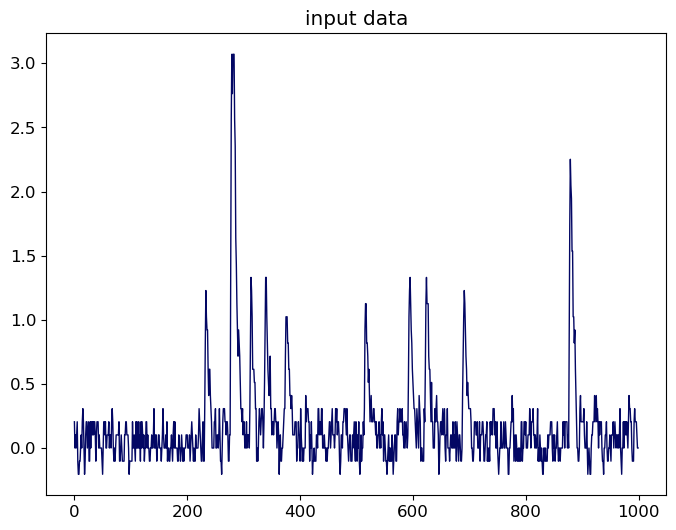

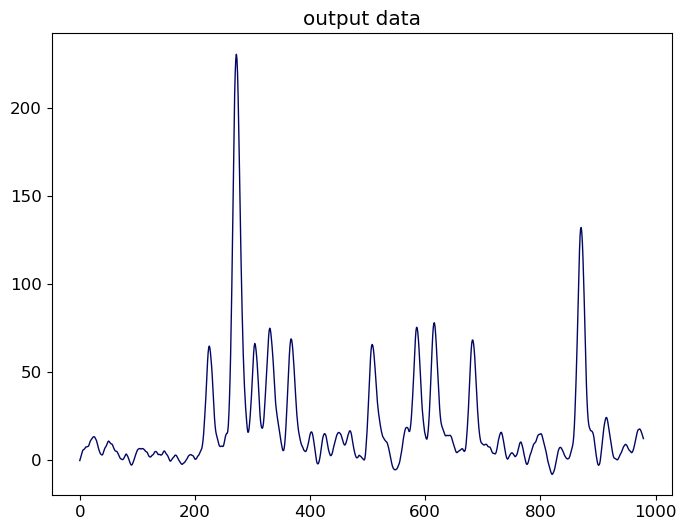

In [7]:
output = torch.tensor(output, dtype = torch.float)

#plot the graph
plt.figure()
plt.plot(torch.flatten(data),color='xkcd:darkblue',lw=1)
plt.title("input data")
plt.show()

plt.figure()
plt.plot(torch.flatten(output),color='xkcd:darkblue',lw=1)
plt.title("output data")
plt.show()

As we can see from the output data, for the specific kernel we pick, it smoothes out the original input data and pick out the peaks from the input data as expected.

## Building Model and Testing
In this section we would build our neural network model with some arbitrary hyperparameters that we will fine tune in the following section. In addition, we would also write function to perform training and model mearsurement.

In [8]:
# first of all define the net we are going to use
class Conv1DNet(nn.Module):
    def __init__(self, kernel_size_1, kernel_size_2, pool_size, depth_1, depth_2):
        super().__init__()
        self.conv1 = nn.Conv1d(1,depth_1,kernel_size_1)
        self.conv2 = nn.Conv1d(depth_1,depth_2,kernel_size_2)
        self.pool  = nn.MaxPool1d(pool_size)
        dim = int((int((1001-kernel_size_1)/pool_size) - kernel_size_2+1)/pool_size) # the size of the data after 2 Conv1D and Maxpooling
        self.L1 = nn.Linear(dim*depth_2, 64)
        self.L2 = nn.Linear(64,32)
        self.L3 = nn.Linear(32,2)
    
    def forward(self, x):
        x = torch.tensor(x, dtype = self.conv1.weight.dtype)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape) # for the purpose of debugging
        x = torch.flatten(x,1)
        #print(x.shape)
        x = F.relu(self.L1(x))
        x = F.relu(self.L2(x))
        x = self.L3(x)
        return x

In [9]:
net = Conv1DNet(40,40,5,3,6)
from torchinfo import summary
summary(net, (1,1,1000))

Layer (type:depth-idx)                   Output Shape              Param #
Conv1DNet                                [1, 2]                    --
├─Conv1d: 1-1                            [1, 3, 961]               123
├─MaxPool1d: 1-2                         [1, 3, 192]               --
├─Conv1d: 1-3                            [1, 6, 153]               726
├─MaxPool1d: 1-4                         [1, 6, 30]                --
├─Linear: 1-5                            [1, 64]                   11,584
├─Linear: 1-6                            [1, 32]                   2,080
├─Linear: 1-7                            [1, 2]                    66
Total params: 14,579
Trainable params: 14,579
Non-trainable params: 0
Total mult-adds (M): 0.24
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.06
Estimated Total Size (MB): 0.09

In [10]:
# define the loss function and optimizer
import torch.optim as optim

def train_network(epoch_num,net,learning_rate,momentum,verbose = True):
    # the training function that we use to train our data
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(),lr = learning_rate, momentum = momentum)
    loss_list = [] #keep track of the loss
    for epoch in range(epoch_num): #loop over the data epoch_num times
        running_loss = 0.0
        for i, data in enumerate(train_loader,0):
            x,label = data
            optimizer.zero_grad()
            #train the model
            pred = net(x)
            loss = criterion(pred,label)
            loss.backward()
            optimizer.step()
            #print statistics on loss
            running_loss += loss.item()
            if i % 200 == 199:    # print every 200 mini-batches
                if verbose == True:
                    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
                loss_list.append(running_loss/200)
                running_loss = 0.0
    return loss_list

def validation(net, validation_loader):
    correct = 0
    total = 0
    # we are validating our results and thus we do not need to include the gradient
    with torch.no_grad():
        for data in validation_loader:
            x, label = data
            outputs = net(x)
            _,predicts = torch.max(outputs,1)
            total += label.size(0)
            correct += (predicts == label).sum().item()
    accuracy = 100 * correct/total
    print(f'Accuracy of the network on the {total} test images: {accuracy:.2f} %')
    return accuracy

[1,   200] loss: 0.663
[1,   400] loss: 0.295
[1,   600] loss: 0.208
[1,   800] loss: 0.120
[1,  1000] loss: 0.334
[1,  1200] loss: 0.212
[1,  1400] loss: 0.140
[1,  1600] loss: 0.126
[2,   200] loss: 0.081
[2,   400] loss: 0.132
[2,   600] loss: 0.157
[2,   800] loss: 0.096
[2,  1000] loss: 0.154
[2,  1200] loss: 0.118
[2,  1400] loss: 0.124
[2,  1600] loss: 0.087
[3,   200] loss: 0.076
[3,   400] loss: 0.137
[3,   600] loss: 0.080
[3,   800] loss: 0.115
[3,  1000] loss: 0.073
[3,  1200] loss: 0.119
[3,  1400] loss: 0.077
[3,  1600] loss: 0.074
[4,   200] loss: 0.089
[4,   400] loss: 0.066
[4,   600] loss: 0.079
[4,   800] loss: 0.086
[4,  1000] loss: 0.125
[4,  1200] loss: 0.083
[4,  1400] loss: 0.082
[4,  1600] loss: 0.091
[5,   200] loss: 0.082
[5,   400] loss: 0.077
[5,   600] loss: 0.065
[5,   800] loss: 0.113
[5,  1000] loss: 0.106
[5,  1200] loss: 0.065
[5,  1400] loss: 0.083
[5,  1600] loss: 0.065
[6,   200] loss: 0.093
[6,   400] loss: 0.081
[6,   600] loss: 0.077
[6,   800] 

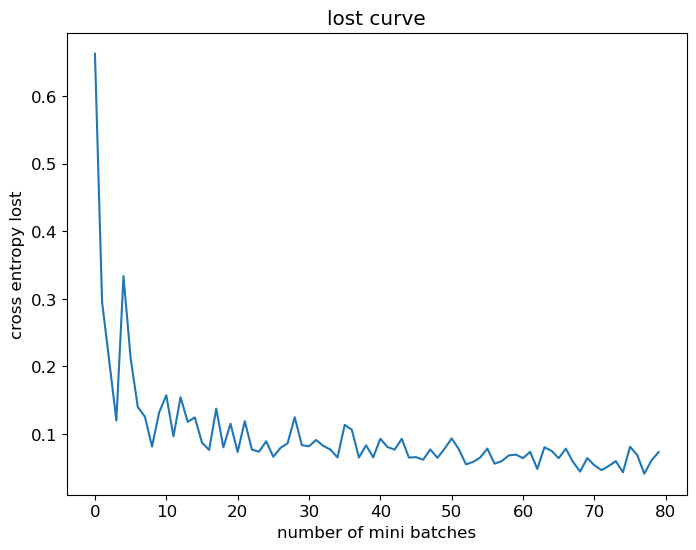

In [12]:
# the macros we can adjust
learning_rate = 1e-3
momentum = 0.9

# each mini batch has lenght of 200
loss_list = train_network(10,net,learning_rate,momentum)
plt.figure()
plt.title("lost curve")
plt.xlabel("number of mini batches")
plt.ylabel("cross entropy lost")
plt.plot(loss_list)
plt.show()

In [13]:
validation(net, val_loader)

Accuracy of the network on the 3690 test images: 97.62 %


97.61517615176152

As we can see from the lost graph, we can claim that the training process is working properly since the lost decreases as the number of mini batches increase, but it halts to decrease but rather oscillates after 20 mini batches.

Furthermore from the accuracy for the network trained on the validation data set is 97%, which performs better than 95% - benchmark value. However, we are looking for a model with prediction accuracy higher than 99%. Thus, we can still fine tuning the hyper parameters to get a higher accuracy.

And now we would need a ROC curve and AUC metric to see the performance of our model.

In [15]:
from sklearn import metrics
def roc_curve(net,validation_loader, plot = True):
    total_pred = []
    total_label = []
    with torch.no_grad():
        for data in validation_loader:
            x, label = data
            outputs = net(x)
            predicts = torch.tensor(F.softmax(outputs), dtype = torch.float)[:,1]
            total_pred += predicts
            total_label += label
    # get the roc curve 
    fpr, tpr, threshold = metrics.roc_curve(total_label, total_pred)
    # if plot = True, plot the roc curve
    if plot == True:
        plt.title("ROC Curve")
        plt.xlabel("False positive rate")
        plt.ylabel("True positive rate")
        plt.grid()
        plt.plot(fpr,tpr)
        plt.show()
    auc_score = 100 * metrics.roc_auc_score(total_label, total_pred)
    print(f"The AUC score is {auc_score:.3f}%")
    return [auc_score, fpr, tpr, threshold]

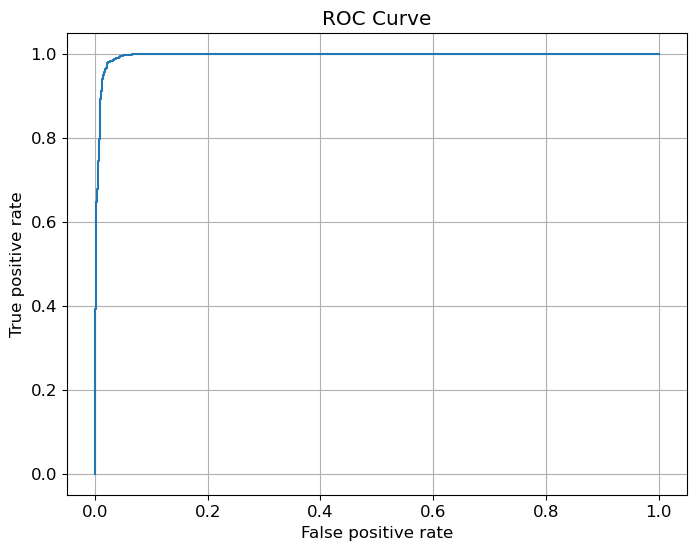

The AUC score is 99.559%


In [15]:
metric = roc_curve(net,val_loader)

We can see the AUC score is incredibly high, which suggests that this data set is relatively easy to be distinguished. And it is indeed the case since we can pretty much tell the difference between the two dataset by our eyes.  

## Fine Tuning the Parameters

And now, with all the net and metric implemented on the net, we are able to fine tuning the hyper parameters to optimize the performance of our model.

And before we fine tuning the hyper parameters, let us firstly list out all the hyperparameters we can tune for this problem:
1. number of CNN networks: $n_{net}$
2. the depth of CNN networks: $d_{i}$ for $i \in \{1,2,...,n\}$
3. the kernel size of CNN networks: $k_{i}$ for $i \in \{1,2,...,n\}$
4. maxpooling size: $d_{p}$ (we assume we use the same pool but in general we can have different max pooling)
5. number of epoch: $n_{epoch}$
6. learning rate: $lr$
7. momentum : $p$

As a result, in general we will have $2n + 5$ hyperparameters to fine tune, which is really impossible to do when $n$ is large. As a result, we will fix $n$ number equals to 2 and do the fine tuning respectively.

In addition, note that there are some parameters that do not depend on $n$, namely the number of epoch, learning rate and momentum. Thus, we will for starter to fine tuning those parameters and then find some optimal value and stick with those value for the rest of hyper fine tuning process.

In [12]:
# import timing module
import time

def train_and_measure(kernel_size_1, kernel_size_2, pool_size,
                      depth_1, depth_2, n_epoch, learning_rate, 
                      momentum, validation_loader):
    net = Conv1DNet(kernel_size_1, kernel_size_2, pool_size, depth_1, depth_2)
    start = time.time()
    _ = train_network(n_epoch,net,learning_rate,momentum, verbose = False)
    end = time.time()
    training_time = end - start
    acc = validation(net, validation_loader)
    metric = roc_curve(net, validation_loader, plot = False)
    auc = metric[0]
    return training_time, acc, auc

In [41]:
#firstly we will try to fine tuning the epoch number
epoch_num_list = np.arange(1,16)
acc_list_epoch = []
auc_list_epoch = []
time_list_epoch = []
for epoch_num in epoch_num_list:
    print(f"current epoch_num is {epoch_num}")
    training_time, acc, auc = train_and_measure(40,40,5,3,6,epoch_num,1e-3,0.9,val_loader)
    print(f"training time is {training_time}")
    time_list_epoch.append(training_time)
    acc_list_epoch.append(acc)
    auc_list_epoch.append(auc)

current epoch_num is 1
Accuracy of the network on the 3690 test images: 96.50 %
The AUC score is 99.159%
training time is 10.374998092651367
current epoch_num is 2
Accuracy of the network on the 3690 test images: 97.18 %
The AUC score is 99.409%
training time is 23.355998754501343
current epoch_num is 3
Accuracy of the network on the 3690 test images: 97.40 %
The AUC score is 99.461%
training time is 27.11099672317505
current epoch_num is 4
Accuracy of the network on the 3690 test images: 97.34 %
The AUC score is 99.505%
training time is 36.75071620941162
current epoch_num is 5
Accuracy of the network on the 3690 test images: 97.51 %
The AUC score is 99.316%
training time is 61.99276518821716
current epoch_num is 6
Accuracy of the network on the 3690 test images: 97.53 %
The AUC score is 99.543%
training time is 80.68108320236206
current epoch_num is 7
Accuracy of the network on the 3690 test images: 97.62 %
The AUC score is 99.543%
training time is 70.2886791229248
current epoch_num i

In [27]:
def plot(acc_list, auc_list, time_list, plot_list, xlabel):
    plt.figure()
    plt.title("accuracy curve")
    plt.xlabel(xlabel)
    plt.ylabel("accuracy(%)")
    #plt.ylim([90,100])
    plt.grid()
    plt.plot(plot_list, acc_list)
    plt.show()

    plt.figure()
    plt.title("auc curve")
    plt.xlabel(xlabel)
    plt.ylabel("auc score(%)")
    #plt.ylim([90,100])
    plt.grid()
    plt.plot(plot_list, auc_list)
    plt.show()

    plt.figure()
    plt.title("training time plot")
    plt.xlabel(xlabel)
    plt.ylabel("training time(s)")
    plt.grid()
    plt.plot(plot_list, time_list)
    plt.show()
    print(f"The {xlabel} for the highest accuracy is {plot_list[acc_list.index(max(acc_list))]}, its value is {max(acc_list):.3f}%")
    print(f"The {xlabel} for the highest auc score is {plot_list[auc_list.index(max(auc_list))]}, its value is {max(auc_list):.3f}%")
    return  

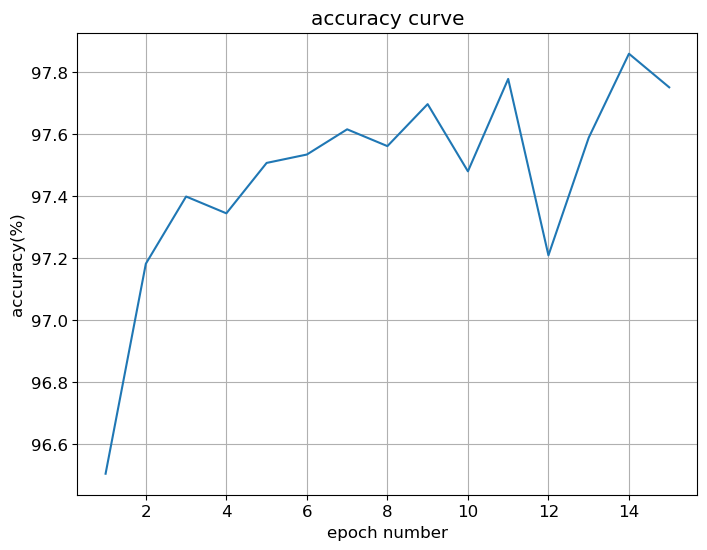

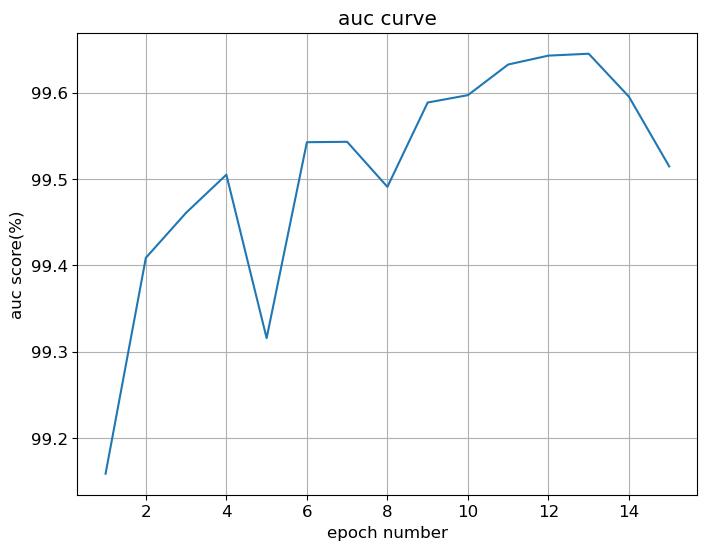

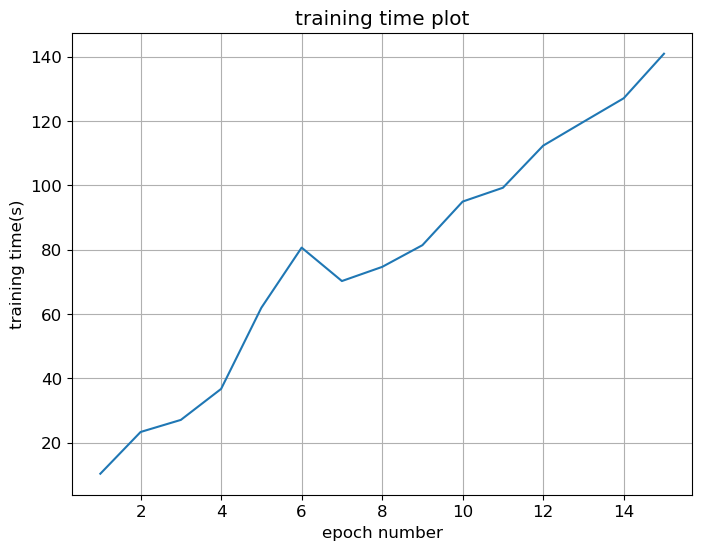

The epoch number for the highest accuracy is 14, its value is 97.859%
The epoch number for the highest auc score is 13, its value is 99.645%


In [43]:
plot(acc_list_epoch, auc_list_epoch, time_list_epoch,epoch_num_list, "epoch number")   

As we can see from the AUC score curve and the accuracy curve, they are both oscillating. In addition, with more epoch number, the accuracy and AUC score does show a trend of increasing, which is expected. However, that does not mean we should just increase the epoch number indefinitely since if we look at the training time curve, we notice that the training time also increases linearly with the training epoch number, as expected. As a result, we should define a cut-off value where the AUC score curve and accuracy score curve is mainly oscillating. Based on that principle, we choose the epoch number, $n_{epoch}$, to be 7.

And now, let us try to fine tune the learning rate and the momentum

In [44]:
# first try the learning rate
lr_list = np.linspace(1e-4,1e-2,15) # try out 15 different learning rates
acc_list_lr = []
auc_list_lr = []
time_list_lr = []
for lr in lr_list:
    print(f"current learning rate is {lr}")
    training_time, acc, auc = train_and_measure(40,40,5,3,6,7,lr,0.9,val_loader)
    print(f"training time is {training_time}")
    time_list_lr.append(training_time)
    acc_list_lr.append(acc)
    auc_list_lr.append(auc)

current learning rate is 0.0001
Accuracy of the network on the 3690 test images: 96.69 %
The AUC score is 99.200%
training time is 68.98668336868286
current learning rate is 0.0008071428571428573
Accuracy of the network on the 3690 test images: 97.32 %
The AUC score is 99.624%
training time is 63.69800019264221
current learning rate is 0.0015142857142857145
Accuracy of the network on the 3690 test images: 96.91 %
The AUC score is 99.425%
training time is 63.49528765678406
current learning rate is 0.0022214285714285717
Accuracy of the network on the 3690 test images: 92.71 %
The AUC score is 97.094%
training time is 71.32858419418335
current learning rate is 0.002928571428571429
Accuracy of the network on the 3690 test images: 97.62 %
The AUC score is 99.568%
training time is 64.0091540813446
current learning rate is 0.003635714285714286
Accuracy of the network on the 3690 test images: 96.94 %
The AUC score is 99.397%
training time is 64.940603017807
current learning rate is 0.004342857

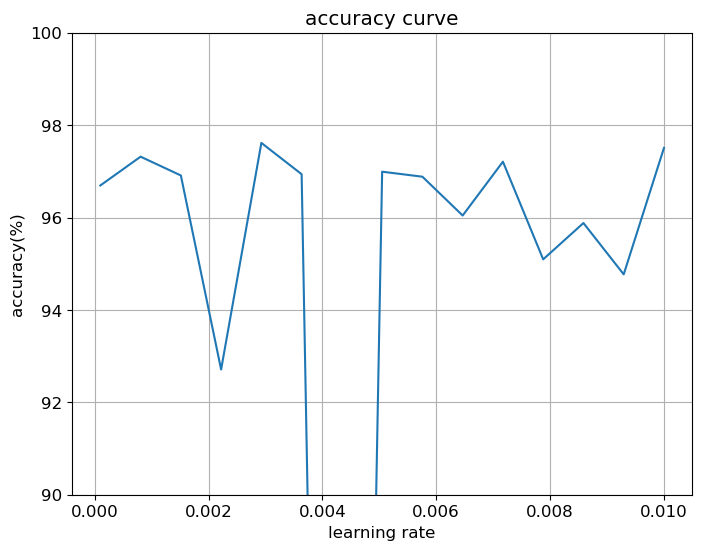

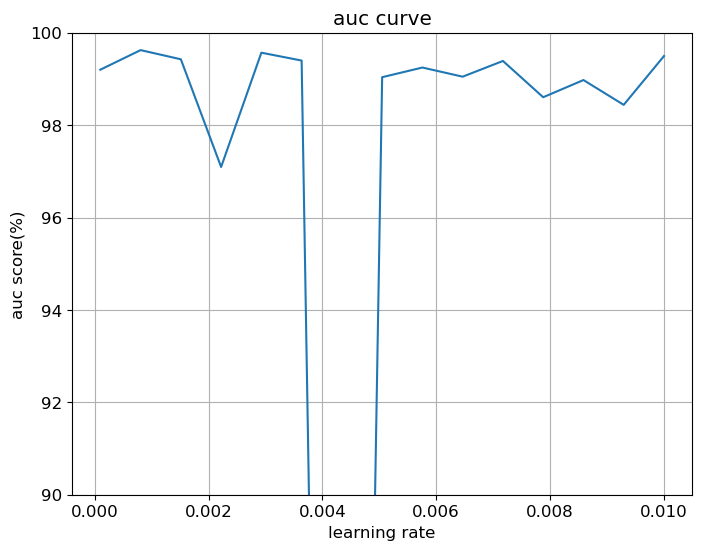

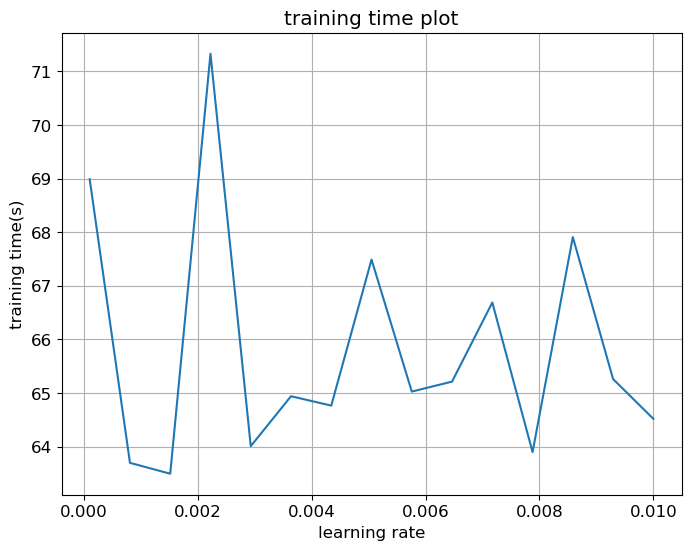

The learning rate for the highest accuracy is 0.002928571428571429, its value is 97.615%
The learning rate for the highest auc score is 0.0008071428571428573, its value is 99.624%


In [51]:
plot(acc_list_lr, auc_list_lr, time_list_lr, lr_list, "learning rate")

The first thing we can infer from the graph is that there is one specific learning rate that performs really bad, and we can narrow down our region to something between 0.003 to 0.0008, and based on that, we can try again.

In [33]:
# first try the learning rate
lr_list_narrow = np.linspace(0.0008,0.003,10) # try out 10 different learning rates
acc_list_lr_narrow = []
auc_list_lr_narrow = []
time_list_lr_narrow = []
for lr in lr_list_narrow:
    print(f"current learning rate is {lr}")
    training_time, acc, auc = train_and_measure(40,40,5,3,6,7,lr,0.9,val_loader)
    print(f"training time is {training_time}")
    time_list_lr_narrow.append(training_time)
    acc_list_lr_narrow.append(acc)
    auc_list_lr_narrow.append(auc)

current learning rate is 0.0008
Accuracy of the network on the 3690 test images: 97.86 %
The AUC score is 99.554%
training time is 49.05799961090088
current learning rate is 0.0010444444444444446
Accuracy of the network on the 3690 test images: 98.08 %
The AUC score is 99.611%
training time is 50.14599943161011
current learning rate is 0.001288888888888889
Accuracy of the network on the 3690 test images: 97.37 %
The AUC score is 99.493%
training time is 51.39600157737732
current learning rate is 0.0015333333333333336
Accuracy of the network on the 3690 test images: 97.72 %
The AUC score is 99.498%
training time is 50.26799774169922
current learning rate is 0.0017777777777777779
Accuracy of the network on the 3690 test images: 95.72 %
The AUC score is 99.168%
training time is 51.46000123023987
current learning rate is 0.0020222222222222226
Accuracy of the network on the 3690 test images: 97.75 %
The AUC score is 99.411%
training time is 51.63900065422058
current learning rate is 0.00226

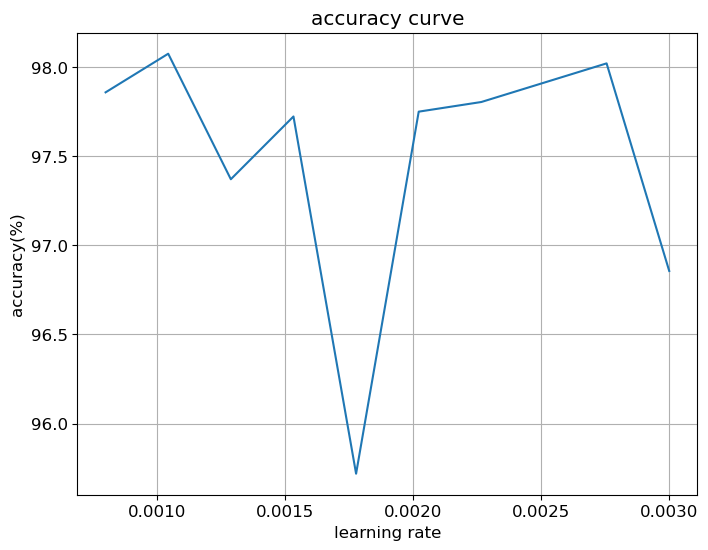

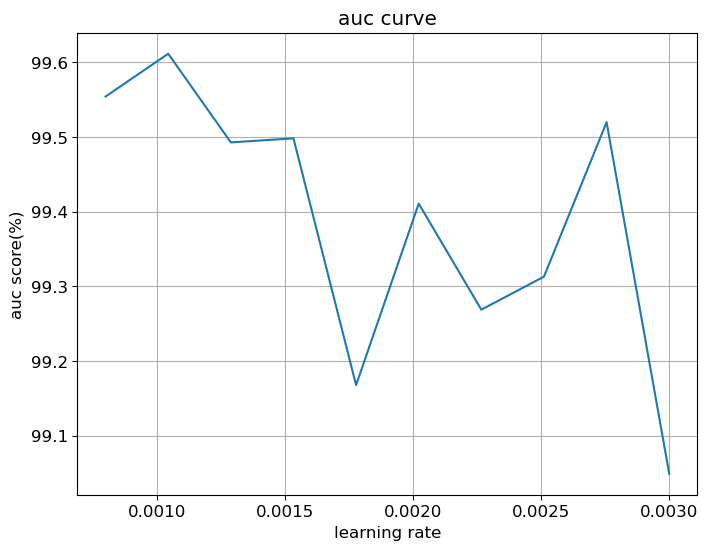

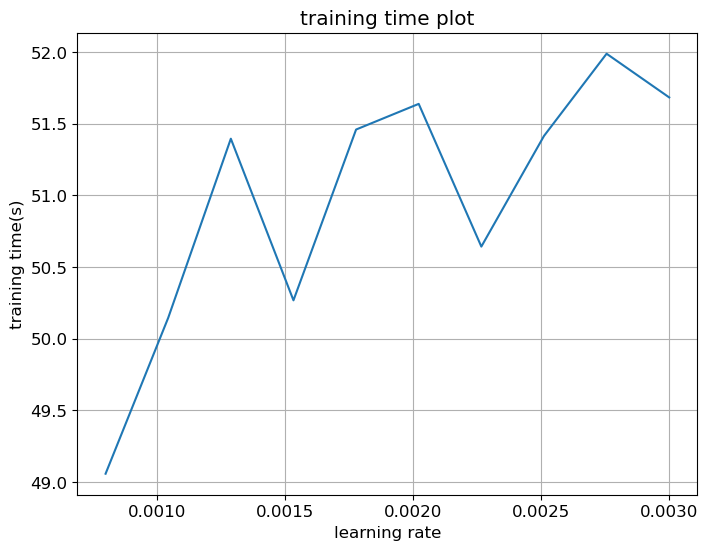

The learning rate for the highest accuracy is 0.0010444444444444446, its value is 98.076%
The learning rate for the highest auc score is 0.0010444444444444446, its value is 99.611%


In [34]:
plot(acc_list_lr_narrow, auc_list_lr_narrow, time_list_lr_narrow, lr_list_narrow, "learning rate")

we can see that 1.05e-3 seems to be a good learning rate for it results in the highest AUC score. and now we can try to fine tune the momentum

In [55]:
#fine tune momentum
momentum_list = np.linspace(0.3,1,10)
acc_list_mom = []
auc_list_mom = []
time_list_mom = []
for momentum in momentum_list:
    print(f"current momentum is {momentum}")
    training_time, acc, auc = train_and_measure(40,40,5,3,6,7,1.05e-3,momentum,val_loader)
    print(f"training time is {training_time}")
    acc_list_mom.append(acc)
    auc_list_mom.append(auc) 
    time_list_mom.append(training_time)

current momentum is 0.3
Accuracy of the network on the 3690 test images: 97.45 %
The AUC score is 99.306%
training time is 63.55703163146973
current momentum is 0.37777777777777777
Accuracy of the network on the 3690 test images: 97.15 %
The AUC score is 99.277%
training time is 64.8221378326416
current momentum is 0.45555555555555555
Accuracy of the network on the 3690 test images: 97.13 %
The AUC score is 99.346%
training time is 63.68581509590149
current momentum is 0.5333333333333333
Accuracy of the network on the 3690 test images: 97.10 %
The AUC score is 99.437%
training time is 63.819188356399536
current momentum is 0.6111111111111112
Accuracy of the network on the 3690 test images: 97.02 %
The AUC score is 99.367%
training time is 68.1869854927063
current momentum is 0.6888888888888889
Accuracy of the network on the 3690 test images: 97.37 %
The AUC score is 99.516%
training time is 64.85499954223633
current momentum is 0.7666666666666666
Accuracy of the network on the 3690 tes

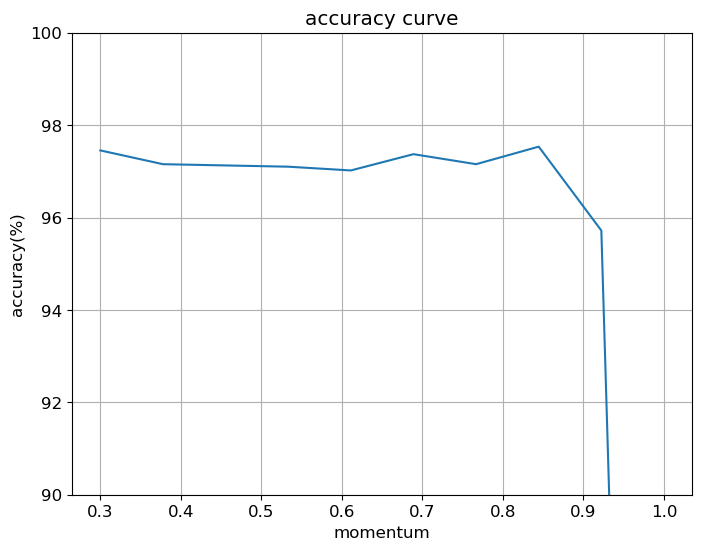

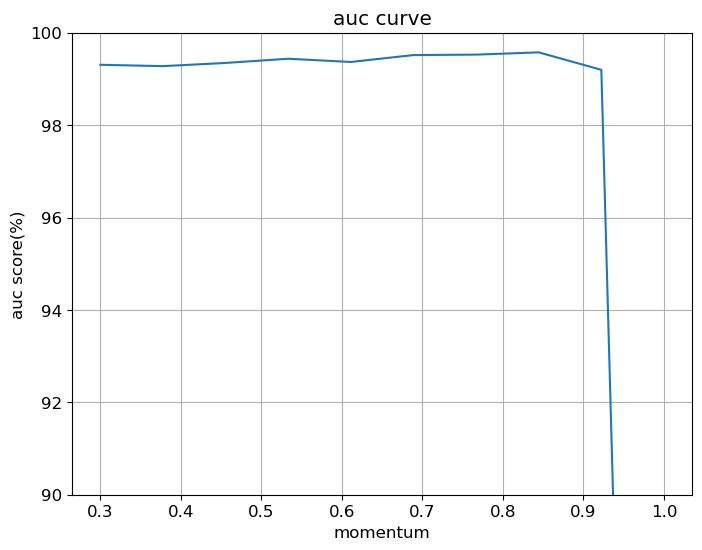

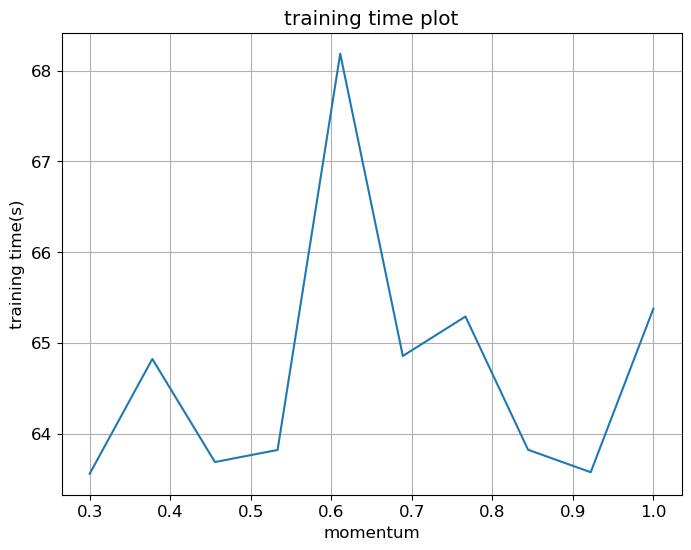

The momentum for the highest accuracy is 0.8444444444444446, its value is 97.534%
The momentum for the highest auc score is 0.8444444444444446, its value is 99.575%


In [56]:
plot(acc_list_mom, auc_list_mom, time_list_mom, momentum_list, "momentum")

We can see that for momentum there seems to exist a unified best value of momentum, to ensure we do have the highest momentum, let us search through a narrower region

In [57]:
momentum_list_narrow = np.linspace(0.8,0.85,10)
acc_list_mom_narrow = []
auc_list_mom_narrow = []
time_list_mom_narrow = []
for momentum in momentum_list_narrow:
    print(f"current momentum is {momentum}")
    training_time, acc, auc = train_and_measure(40,40,5,3,6,7,1.05e-3,momentum,val_loader)
    print(f"training time is {training_time}")
    acc_list_mom_narrow.append(acc)
    auc_list_mom_narrow.append(auc) 
    time_list_mom_narrow.append(training_time)

current momentum is 0.8
Accuracy of the network on the 3690 test images: 97.29 %
The AUC score is 99.518%
training time is 63.37706470489502
current momentum is 0.8055555555555556
Accuracy of the network on the 3690 test images: 97.48 %
The AUC score is 99.540%
training time is 63.570382833480835
current momentum is 0.8111111111111111
Accuracy of the network on the 3690 test images: 97.48 %
The AUC score is 99.592%
training time is 63.30499768257141
current momentum is 0.8166666666666667
Accuracy of the network on the 3690 test images: 97.43 %
The AUC score is 99.489%
training time is 64.75903654098511
current momentum is 0.8222222222222222
Accuracy of the network on the 3690 test images: 97.75 %
The AUC score is 99.605%
training time is 64.02552485466003
current momentum is 0.8277777777777778
Accuracy of the network on the 3690 test images: 97.45 %
The AUC score is 99.481%
training time is 63.66351532936096
current momentum is 0.8333333333333334
Accuracy of the network on the 3690 tes

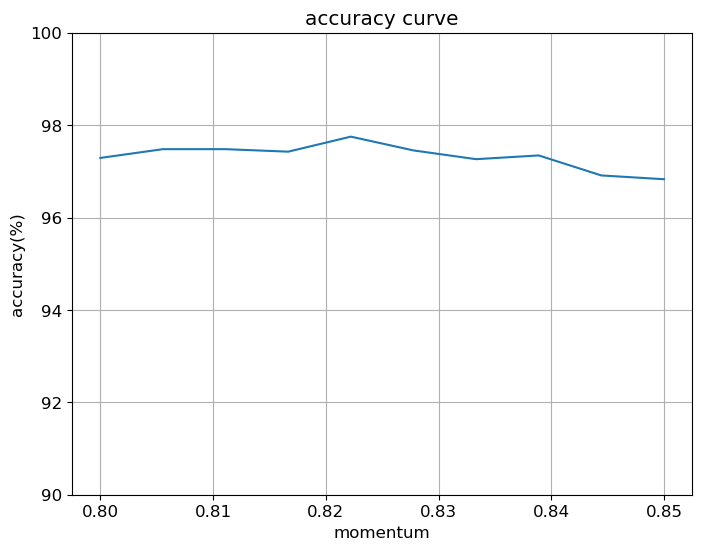

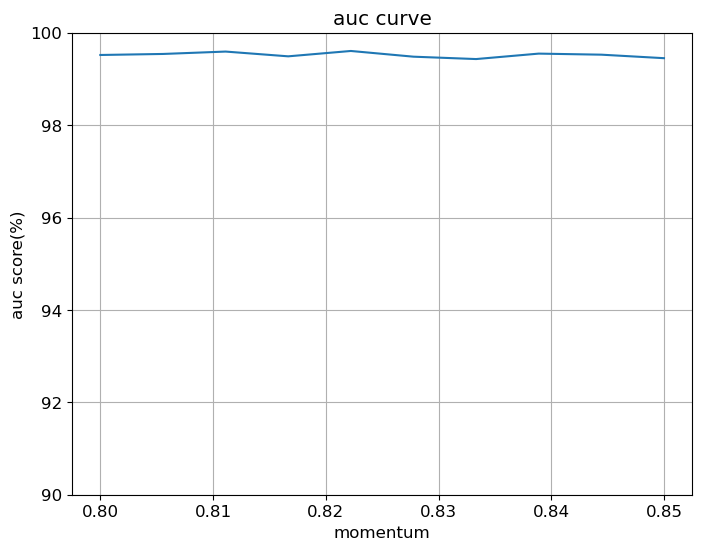

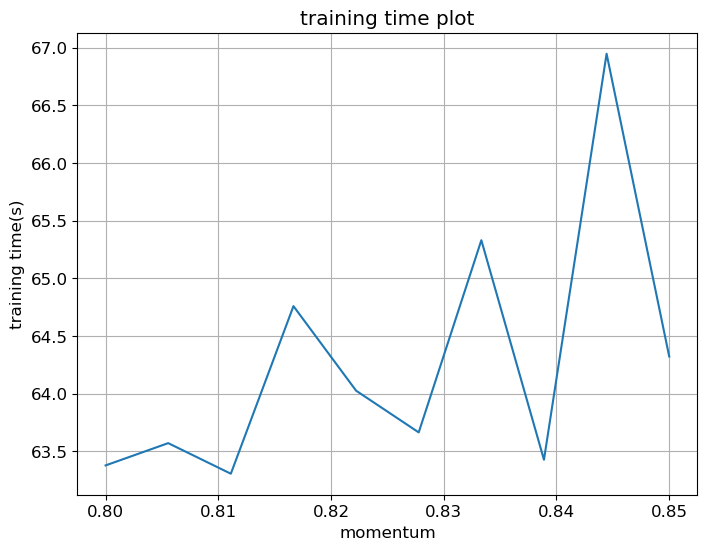

The momentum for the highest accuracy is 0.8222222222222222, its value is 97.751%
The momentum for the highest auc score is 0.8222222222222222, its value is 99.605%


In [58]:
plot(acc_list_mom_narrow, auc_list_mom_narrow, time_list_mom_narrow, momentum_list_narrow, "momentum")

Now we can see that by choosing a momentum of 0.82 seems to be a good choice.

Now, we can try out different pool size.

In [70]:
pool_size_list = np.linspace(1,15,15).astype("int") # note that the highest number we can go here right now is 20
acc_list_pool_size = []
auc_list_pool_size = []
time_list_pool_size = []
for pool_size in pool_size_list:
    print(f"current pool size is {pool_size}")
    training_time, acc, auc = train_and_measure(40,40,pool_size,3,6,7,1.05e-3,0.82,val_loader)
    print(f"training time is {training_time}")
    time_list_pool_size.append(training_time)
    acc_list_pool_size.append(acc)
    auc_list_pool_size.append(auc)

current pool size is 1
Accuracy of the network on the 3690 test images: 97.75 %
The AUC score is 99.594%
training time is 155.60500359535217
current pool size is 2
Accuracy of the network on the 3690 test images: 97.37 %
The AUC score is 99.568%
training time is 86.45242381095886
current pool size is 3
Accuracy of the network on the 3690 test images: 97.43 %
The AUC score is 99.594%
training time is 68.81010627746582
current pool size is 4
Accuracy of the network on the 3690 test images: 97.48 %
The AUC score is 99.590%
training time is 67.12856197357178
current pool size is 5
Accuracy of the network on the 3690 test images: 97.07 %
The AUC score is 99.539%
training time is 68.18751263618469
current pool size is 6
Accuracy of the network on the 3690 test images: 97.78 %
The AUC score is 99.604%
training time is 67.71899890899658
current pool size is 7
Accuracy of the network on the 3690 test images: 97.37 %
The AUC score is 99.366%
training time is 63.43506979942322
current pool size i

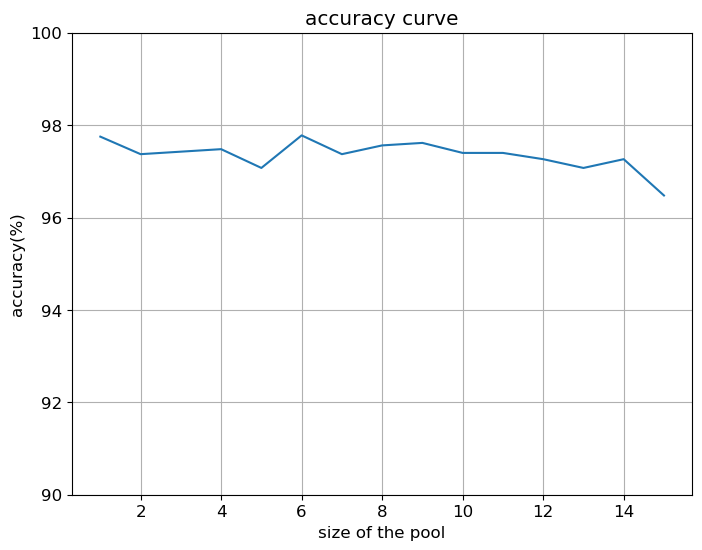

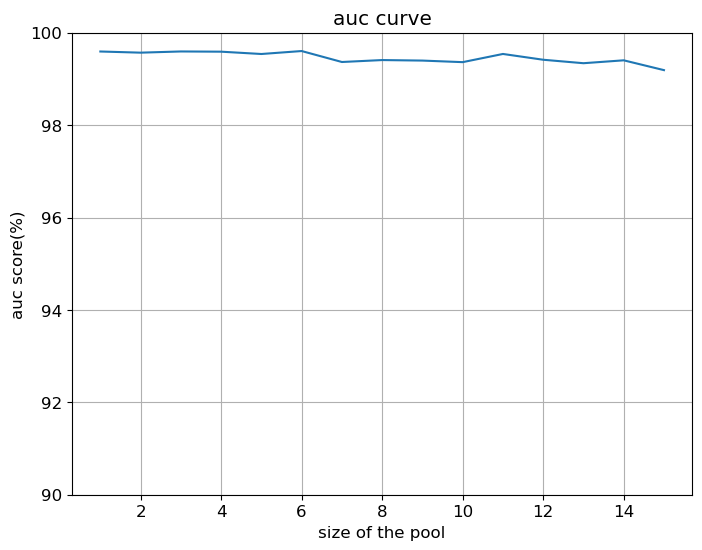

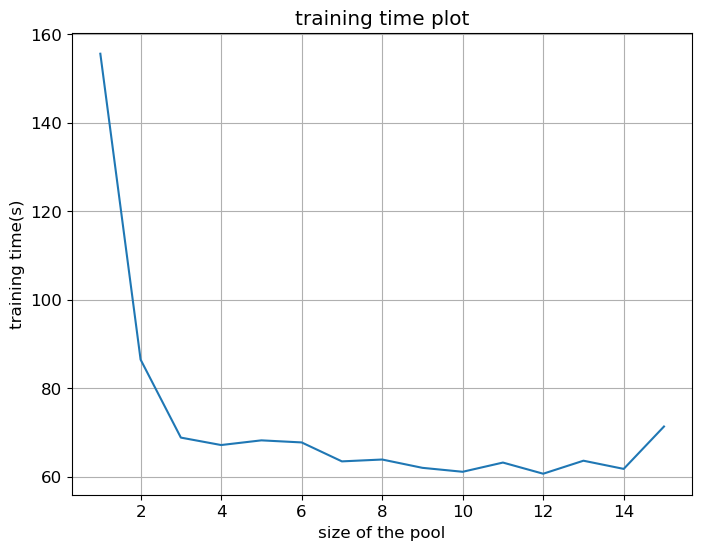

The size of the pool for the highest accuracy is 6, its value is 97.778%
The size of the pool for the highest auc score is 6, its value is 99.604%


In [71]:
plot(acc_list_pool_size, auc_list_pool_size, time_list_pool_size, pool_size_list, "size of the pool")

Note that as the size of the pool increases, the training time decreases as expected, but auc score and accuracy does not necessarily decrease. In fact, the optimal pool size seem to be 6, which would be the hyperparameter that we choose for, firstly, it has the highest accuracy and AUC score, and secondly, the training time for max pooling size of 6 is also relatively smaller.

Now we would like to fine tune the kernel size and depth of CNN and potentially the number of neural network, which is rather complex since those parameters are rather entangled.

We can consider this matter from the perspective of the number of parameters. Both the depth and the kernel size of the CNN would influence the number of parameters, which might suggest their effect is rather entangled. As a result, unlike other hyperparameters we fine tuning before where we assume they are independent from each other (which might not be the case, but weakly coupling is also good enough).

As a result, instead of trying out each individual hyperparameters, we would try the combinations of different hyperparameters.

In order to cut down the dimensionality of the hyperfine parameter space, we would assume the hyperfine parameters for the first layer and the second layer are not correlated, which means that they can be decided separately.

In [19]:
kernel_size_list = [20,40,60,80]
depth_list = [2,5,8,11]
acc_list_CNN1 = []
auc_list_CNN1 = []
time_list_CNN1 = []
for kernel_size in kernel_size_list:
    for depth in depth_list:
        print(f"current kernel size is {kernel_size}")
        print(f"current depth is {depth}")
        training_time, acc, auc = train_and_measure(kernel_size,40,depth,6,6,7,1.05e-3,0.82,val_loader)
        print(f"the training time is {training_time}")
        time_list_CNN1.append(training_time)
        acc_list_CNN1.append(acc)
        auc_list_CNN1.append(auc)


current kernel size is 20
current depth is 2
Accuracy of the network on the 3690 test images: 97.89 %
The AUC score is 99.476%
the training time is 75.85250806808472
current kernel size is 20
current depth is 5
Accuracy of the network on the 3690 test images: 97.56 %
The AUC score is 99.486%
the training time is 53.002033948898315
current kernel size is 20
current depth is 8
Accuracy of the network on the 3690 test images: 97.67 %
The AUC score is 99.465%
the training time is 49.96300005912781
current kernel size is 20
current depth is 11
Accuracy of the network on the 3690 test images: 97.83 %
The AUC score is 99.474%
the training time is 48.787002086639404
current kernel size is 40
current depth is 2
Accuracy of the network on the 3690 test images: 97.97 %
The AUC score is 99.559%
the training time is 78.42099785804749
current kernel size is 40
current depth is 5
Accuracy of the network on the 3690 test images: 97.86 %
The AUC score is 99.542%
the training time is 55.15899872779846
c

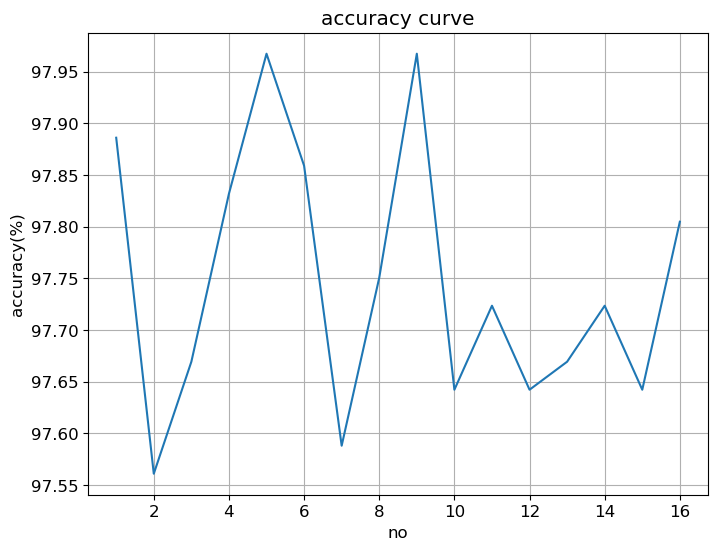

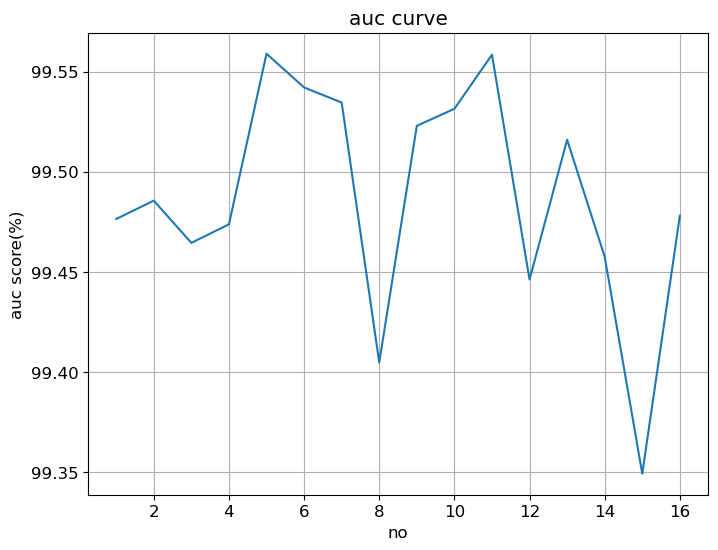

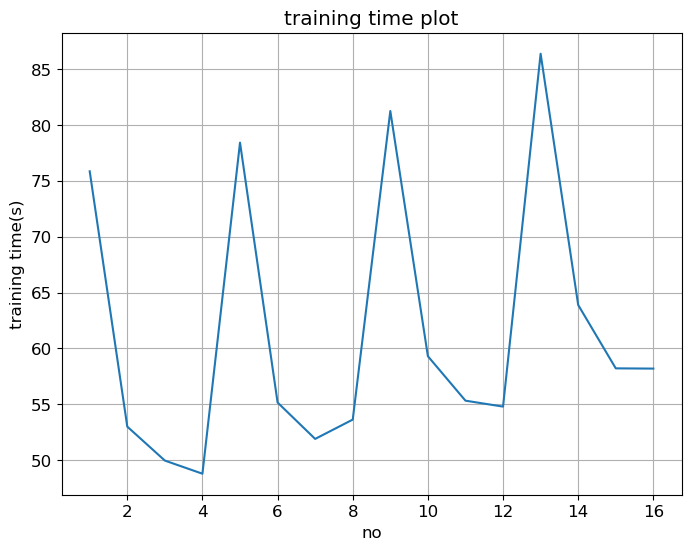

The no for the highest accuracy is 5, its value is 97.967%
The no for the highest auc score is 5, its value is 99.559%


In [29]:
plot(acc_list_CNN1, auc_list_CNN1, time_list_CNN1, np.arange(1,len(acc_list_CNN1)+1), "no")

Though the graph is not very informative about the right combination, it does show us two things. Firstly, the AUC score and accuracy does not necessarily increase with the increase of the number of parameters. Secondly, the training time for surely does increase with the number of parameters. And the best performance combination in terms of the accuracy score and AUC score is kernel size = 40 and depth = 2

As a result, we can do a narrower search between kernel size in [30,50] with a depth [2,3,4]

In [21]:
kernel_size_list_narrow1 = np.linspace(30,50,10).astype("int")
depth_list_narrow1 = [2,3,4]
acc_list_CNN1_narrow = []
auc_list_CNN1_narrow = []
time_list_CNN1_narrow = []
for kernel_size in kernel_size_list_narrow1:
    for depth in depth_list_narrow1:
        print(f"current kernel size is {kernel_size}")
        print(f"current depth is {depth}")
        training_time, acc, auc = train_and_measure(kernel_size,40,6,depth,6,7,1.05e-3,0.82,val_loader)
        print(f"the training time is {training_time}")
        time_list_CNN1_narrow.append(training_time)
        acc_list_CNN1_narrow.append(acc)
        auc_list_CNN1_narrow.append(auc)

current kernel size is 30
current depth is 2
Accuracy of the network on the 3690 test images: 97.89 %
The AUC score is 99.464%
the training time is 45.278998613357544
current kernel size is 30
current depth is 3
Accuracy of the network on the 3690 test images: 97.62 %
The AUC score is 99.556%
the training time is 48.623995780944824
current kernel size is 30
current depth is 4
Accuracy of the network on the 3690 test images: 97.67 %
The AUC score is 99.491%
the training time is 53.25106930732727
current kernel size is 32
current depth is 2
Accuracy of the network on the 3690 test images: 97.83 %
The AUC score is 99.484%
the training time is 46.7599995136261
current kernel size is 32
current depth is 3
Accuracy of the network on the 3690 test images: 97.70 %
The AUC score is 99.440%
the training time is 48.87999939918518
current kernel size is 32
current depth is 4
Accuracy of the network on the 3690 test images: 97.86 %
The AUC score is 99.542%
the training time is 49.22299861907959
cur

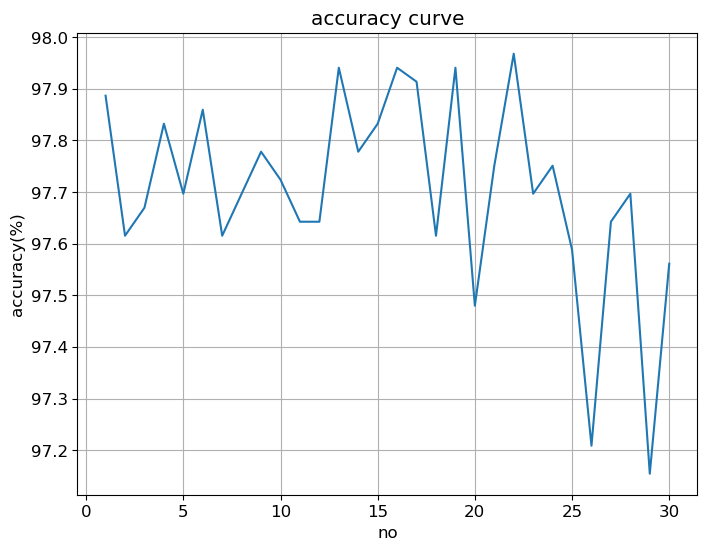

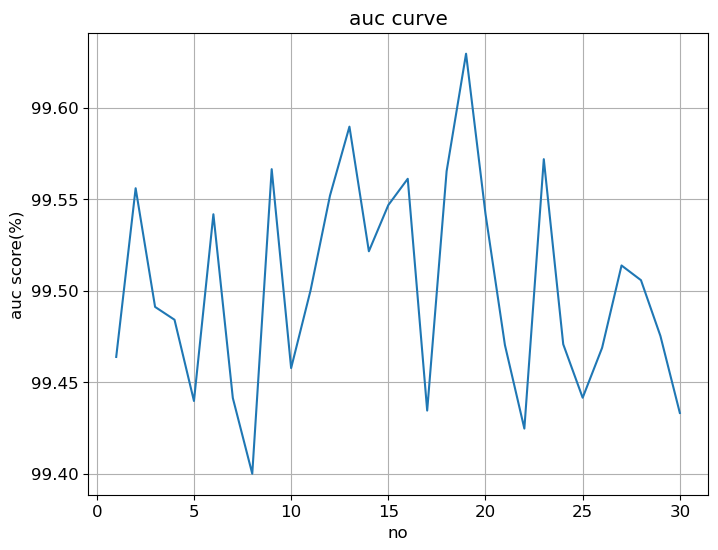

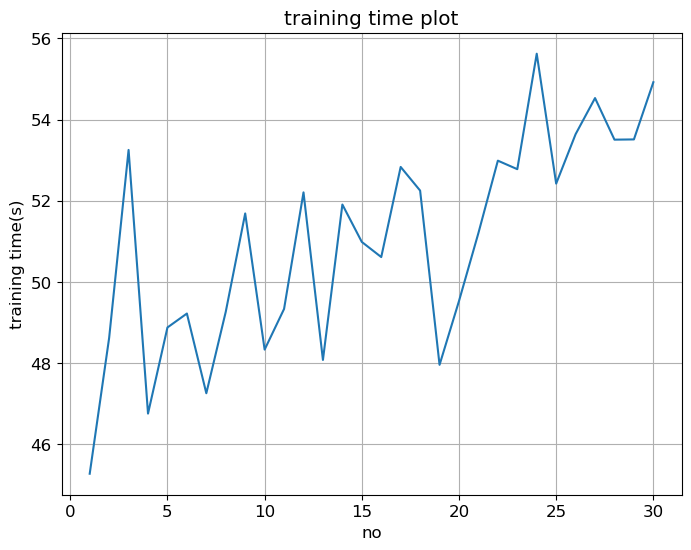

The no for the highest accuracy is 22, its value is 97.967%
The no for the highest auc score is 19, its value is 99.630%


In [30]:
plot(acc_list_CNN1_narrow, auc_list_CNN1_narrow, time_list_CNN1_narrow, np.arange(1,len(acc_list_CNN1_narrow)+1), "no")

we see that the highest accuracy score is kernel size of 45 and depth of 2, and the highest auc score is kernel size of 43 and depth of 2. And in the spirit of minimizing the number of parameters we are trying to train, we are going to choose kernel size of 43 and depth of 2 as the hyperparameters for our first CNN layer.

And then we apply the similar procedure for the second layer of the CNN

In [24]:
kernel_size_list = [20,40,60,80]
depth_list = [2,5,8,11]
acc_list_CNN2 = []
auc_list_CNN2 = []
time_list_CNN2 = []
for kernel_size in kernel_size_list:
    for depth in depth_list:
        print(f"current kernel size is {kernel_size}")
        print(f"current depth is {depth}")
        training_time, acc, auc = train_and_measure(43,kernel_size,2,depth,6,7,1.05e-3,0.82,val_loader)
        print(f"the training time is {training_time}")
        time_list_CNN2.append(training_time)
        acc_list_CNN2.append(acc)
        auc_list_CNN2.append(auc)


current kernel size is 20
current depth is 2
Accuracy of the network on the 3690 test images: 97.75 %
The AUC score is 99.575%
the training time is 51.57099533081055
current kernel size is 20
current depth is 5
Accuracy of the network on the 3690 test images: 97.91 %
The AUC score is 99.563%
the training time is 65.01100158691406
current kernel size is 20
current depth is 8
Accuracy of the network on the 3690 test images: 97.97 %
The AUC score is 99.588%
the training time is 74.83000230789185
current kernel size is 20
current depth is 11
Accuracy of the network on the 3690 test images: 97.89 %
The AUC score is 99.490%
the training time is 80.89099979400635
current kernel size is 40
current depth is 2
Accuracy of the network on the 3690 test images: 98.05 %
The AUC score is 99.655%
the training time is 57.07200074195862
current kernel size is 40
current depth is 5
Accuracy of the network on the 3690 test images: 97.45 %
The AUC score is 99.658%
the training time is 75.36299896240234
cur

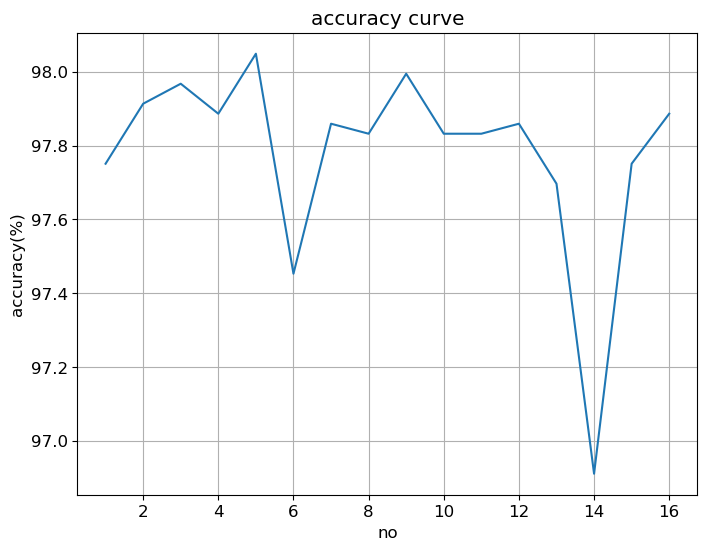

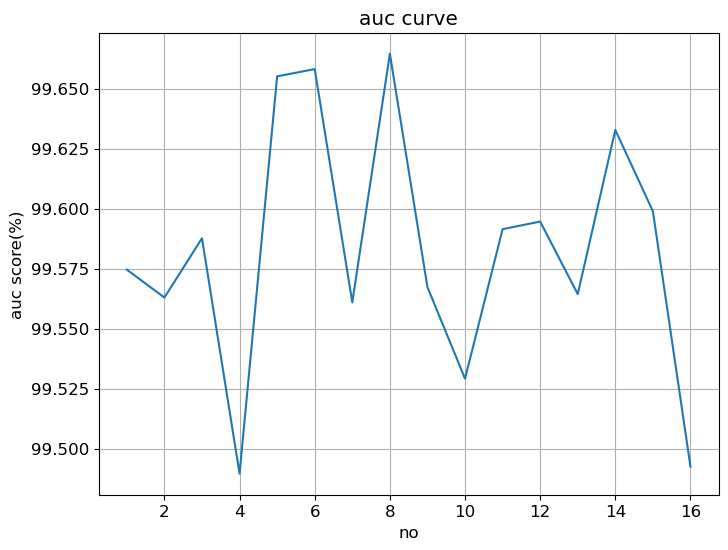

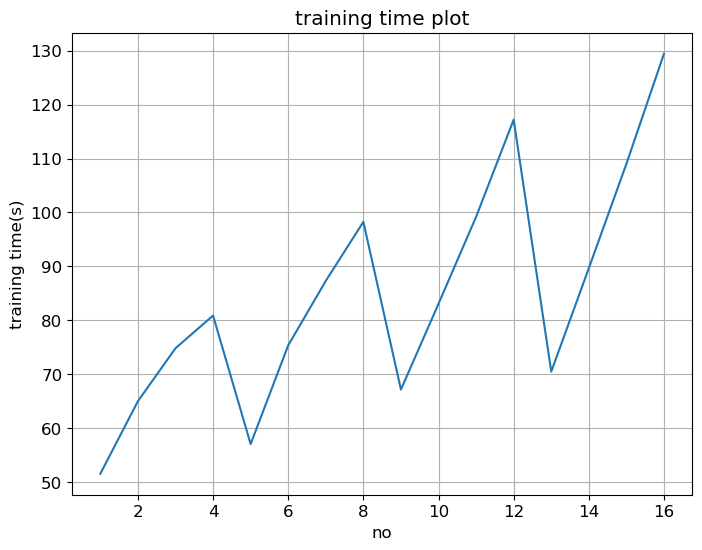

The no for the highest accuracy is 5, its value is 98.049%
The no for the highest auc score is 8, its value is 99.665%


In [31]:
plot(acc_list_CNN2, auc_list_CNN2, time_list_CNN2, np.arange(1,len(acc_list_CNN2)+1), "no")

the highest accuracy is when kernel size is 40 and depth is 2 and the highest AUC score is when kernel size is 40 and depth is 11.
As a result, we will narrow our region to [35,40,45] and depth from [2,12]

In [26]:
kernel_size_list_narrow2 = [35,40,45]
depth_list_narrow2 = np.linspace(2,12,10).astype("int")
acc_list_CNN2_narrow = []
auc_list_CNN2_narrow = []
time_list_CNN2_narrow = []
for kernel_size in kernel_size_list_narrow2:
    for depth in depth_list_narrow2:
        print(f"current kernel size is {kernel_size}")
        print(f"current depth is {depth}")
        training_time, acc, auc = train_and_measure(43,kernel_size,2,depth,6,7,1.05e-3,0.82,val_loader)
        print(f"the training time is {training_time}")
        time_list_CNN2_narrow.append(training_time)
        acc_list_CNN2_narrow.append(acc)
        auc_list_CNN2_narrow.append(auc)

current kernel size is 35
current depth is 2
Accuracy of the network on the 3690 test images: 98.02 %
The AUC score is 99.538%
the training time is 54.973998069763184
current kernel size is 35
current depth is 3
Accuracy of the network on the 3690 test images: 98.05 %
The AUC score is 99.616%
the training time is 62.982518434524536
current kernel size is 35
current depth is 4
Accuracy of the network on the 3690 test images: 97.91 %
The AUC score is 99.453%
the training time is 68.70699977874756
current kernel size is 35
current depth is 5
Accuracy of the network on the 3690 test images: 97.75 %
The AUC score is 99.577%
the training time is 74.99799942970276
current kernel size is 35
current depth is 6
Accuracy of the network on the 3690 test images: 97.94 %
The AUC score is 99.545%
the training time is 75.72500014305115
current kernel size is 35
current depth is 7
Accuracy of the network on the 3690 test images: 97.75 %
The AUC score is 99.589%
the training time is 83.59300351142883
cu

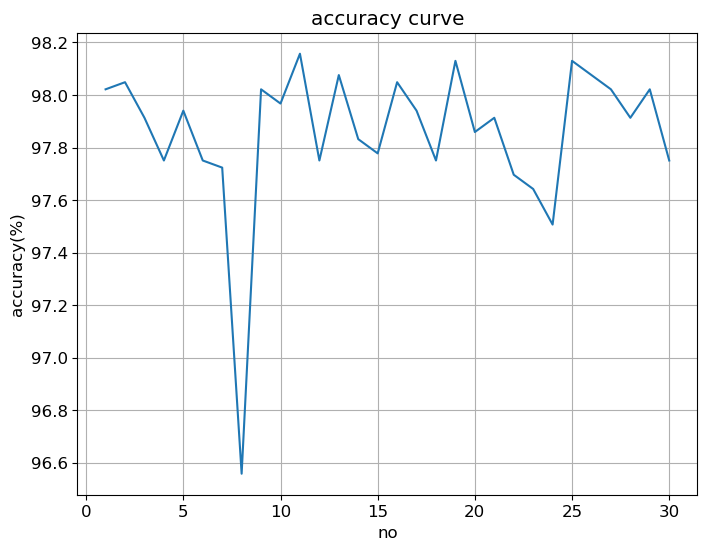

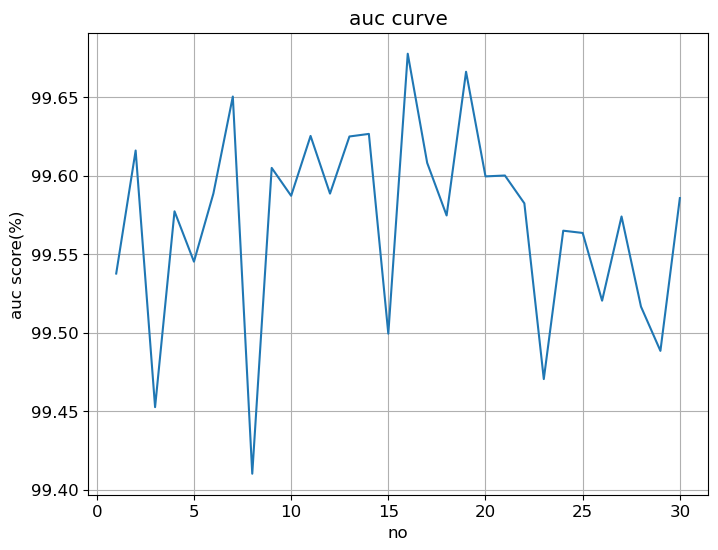

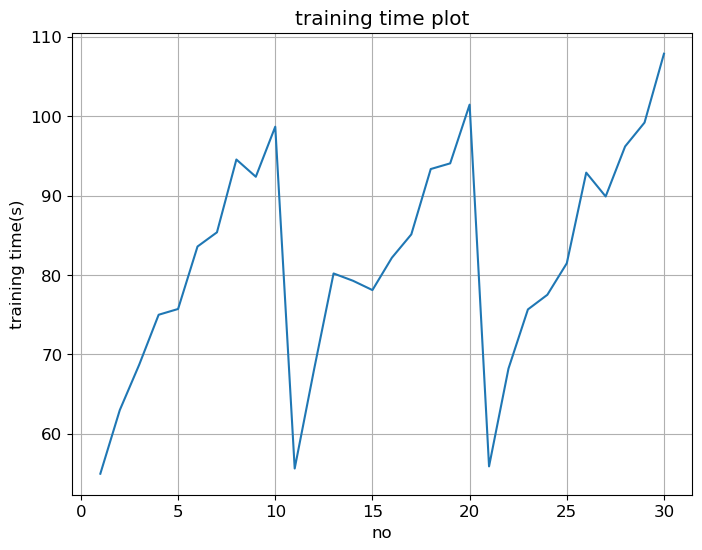

The no for the highest accuracy is 11, its value is 98.157%
The no for the highest auc score is 16, its value is 99.678%


In [32]:
plot(acc_list_CNN2_narrow, auc_list_CNN2_narrow, time_list_CNN2_narrow, np.arange(1,len(acc_list_CNN2_narrow)+1), "no")

we can see that the highest accuracy is when kernel size is 40 and depth is 2 and the highest AUC score is when kernel size is 40 and depth is 7. In the spirit of using less parameters, we choose our final hyperparameter for the second CNN layer to be kernel size 40 and depth 2.

And thus, the eventual configuration of our network is the following

In [39]:
net = Conv1DNet(43,40,2,2,6)
# the final configuration of the network 
summary(net, (1,1,1000))

Layer (type:depth-idx)                   Output Shape              Param #
Conv1DNet                                [1, 2]                    --
├─Conv1d: 1-1                            [1, 2, 958]               88
├─MaxPool1d: 1-2                         [1, 2, 479]               --
├─Conv1d: 1-3                            [1, 6, 440]               486
├─MaxPool1d: 1-4                         [1, 6, 220]               --
├─Linear: 1-5                            [1, 64]                   84,544
├─Linear: 1-6                            [1, 32]                   2,080
├─Linear: 1-7                            [1, 2]                    66
Total params: 87,264
Trainable params: 87,264
Non-trainable params: 0
Total mult-adds (M): 0.38
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.35
Estimated Total Size (MB): 0.39

[1,   200] loss: 0.494
[1,   400] loss: 0.326
[1,   600] loss: 0.190
[1,   800] loss: 0.122
[1,  1000] loss: 0.264
[1,  1200] loss: 0.137
[1,  1400] loss: 0.122
[1,  1600] loss: 0.076
[2,   200] loss: 0.173
[2,   400] loss: 0.099
[2,   600] loss: 0.105
[2,   800] loss: 0.076
[2,  1000] loss: 0.078
[2,  1200] loss: 0.078
[2,  1400] loss: 0.085
[2,  1600] loss: 0.083
[3,   200] loss: 0.078
[3,   400] loss: 0.086
[3,   600] loss: 0.058
[3,   800] loss: 0.078
[3,  1000] loss: 0.091
[3,  1200] loss: 0.098
[3,  1400] loss: 0.113
[3,  1600] loss: 0.075
[4,   200] loss: 0.067
[4,   400] loss: 0.073
[4,   600] loss: 0.090
[4,   800] loss: 0.086
[4,  1000] loss: 0.086
[4,  1200] loss: 0.075
[4,  1400] loss: 0.071
[4,  1600] loss: 0.077
[5,   200] loss: 0.062
[5,   400] loss: 0.098
[5,   600] loss: 0.066
[5,   800] loss: 0.054
[5,  1000] loss: 0.074
[5,  1200] loss: 0.072
[5,  1400] loss: 0.072
[5,  1600] loss: 0.076
[6,   200] loss: 0.076
[6,   400] loss: 0.059
[6,   600] loss: 0.047
[6,   800] 

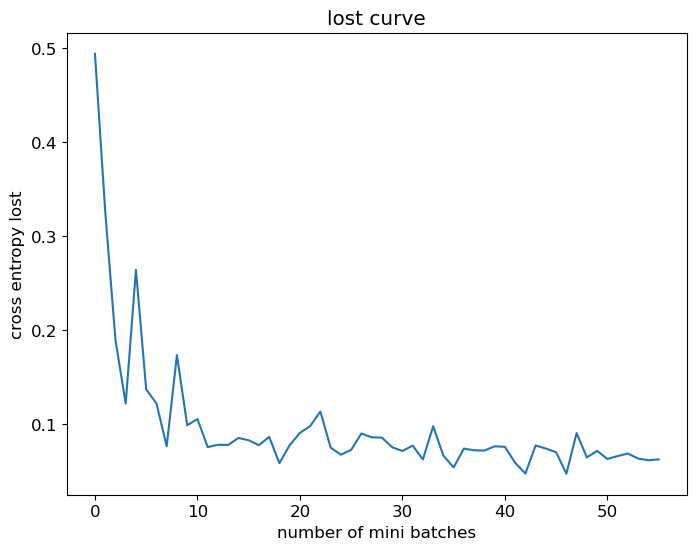

In [40]:
loss_list = train_network(7,net,1.05e-3,0.82)
plt.figure()
plt.title("lost curve")
plt.xlabel("number of mini batches")
plt.ylabel("cross entropy lost")
plt.plot(loss_list)
plt.show()

The trainig curve looks alright and the network is training properly. Now, we will measure the performance of our network on the test set.

In [41]:
accuracy = validation(net,test_loader)

Accuracy of the network on the 3076 test images: 97.98 %


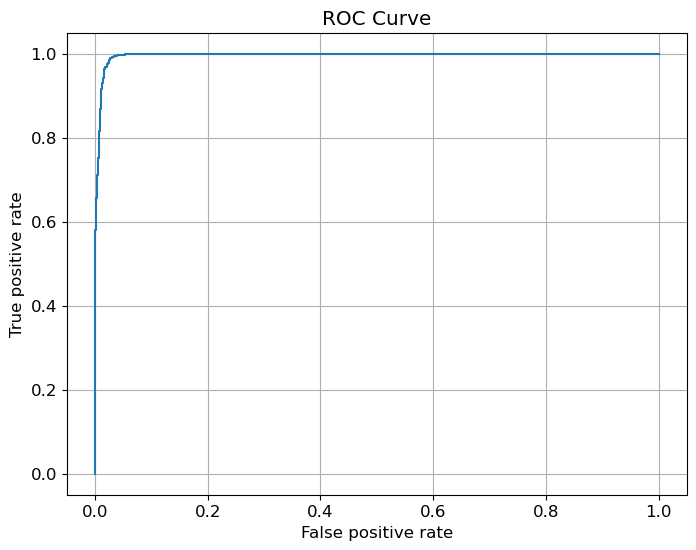

The AUC score is 99.619%


In [42]:
metric = roc_curve(net,test_loader)

## Conclusion
We firstly build a rough 2 CNN layer neural network for the classification, and then we construct a training procedure and 2 different metric, namely the precision and the validation, to measure our performance. And then, we perform a set of fine tuning hyperparameters, we finally decide the architecture of our model and test its performance on the test set. And the final accuracy is 97.98% with AUC score of 99.619%.

Note that such performance is indeed better than the benchmark, which is 95% percent but still short of 1 percent than the optimal accuracy of 99%. And there is a few things that we can do to further optimize the performance. Firstly, note that all the hyperparameters that we tried to use in this mini project are based on two basic principle idea: lower the training time and improve the performance. On the other hand, if we really do want a higher prediction accuracy, one thing we can do is to increase the epoch number - though the performance is not entirely steady, it shows a trend of slowly increasing. Another thing we can do is that we only test out the 2 CNN layer neural network here, but that does not mean it is the only architecture we can have - in principle we can also have other architecturel, namely more layers of CNN neural network. Finally, during the fine tuning of the hyperfine parameters, we assume most of the hyperparameters are independent, which reduce the dimensionality of the hyperfine parameter space by a lot. In real case they do not need to be independent and a more reasonable but more time consuming method is to do many grid searches with all the parameters. But the grid search method becomes in principle impossible if our neural network has many layers, since the hyperparameter space would be too large for any computer to store all the information.